In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree

In [2]:
from IPython.display import display

raw_data      = pd.read_csv('../data/sentence-relations/train.csv', index_col='id')
raw_submissions = pd.read_csv('../data/sentence-relations/test.csv', index_col='id')

# Drop chinese and thai
raw_data = raw_data[raw_data['lang_abv'] != 'zh']
raw_data = raw_data[raw_data['lang_abv'] != 'th']

raw_data = raw_data.drop(columns=['lang_abv', 'language'])
raw_data.index = range(len(raw_data))

additional_data = pd.read_csv('./glue_data/RTE/train.tsv', sep='\t')
additional_data = additional_data.drop(columns=['index'])
additional_data.columns = ['premise', 'hypothesis', 'label']
additional_data['label'] = additional_data['label'].apply(lambda x: 0 if x == 'entailment' else 2)

print(f"Raw data shape: {raw_data.shape}")
print(f"Additional data shape: {additional_data.shape}")

# Merge the two datasets
raw_data = pd.concat([raw_data, additional_data], ignore_index=True)
raw_data = raw_data.drop_duplicates()
raw_data = raw_data.reset_index(drop=True)

print(f"Total data shape: {raw_data.shape}")

training_data, test_data = train_test_split(raw_data, test_size=0.2, random_state=42)

display(additional_data.head())
display(training_data.head())

Raw data shape: (11338, 3)
Additional data shape: (2490, 3)
Total data shape: (13826, 3)


,premise,hypothesis,label
0,No Weapons of Mass Destruction Found in Iraq Yet.,Weapons of Mass Destruction Found in Iraq.,2
1,"A place of sorrow, after Pope John Paul II die...",Pope Benedict XVI is the new leader of the Rom...,0
2,Herceptin was already approved to treat the si...,Herceptin can be used to treat breast cancer.,0
3,"Judie Vivian, chief executive at ProMedica, a ...",The previous name of Ho Chi Minh City was Saigon.,0
4,A man is due in court later charged with the m...,Paul Stewart Hutchinson is accused of having s...,2


,premise,hypothesis,label
9430,Inglish unterscheidet sich von Englisch durch ...,Inglisch ist das Gleiche wie Englisch.,2
8649,His ruthless campaigns resulted in more than 6...,"500,000 Irish died and 100,000 were deported d...",1
758,Televizyon'da bir şeyler izliyoruz.,Televizyondaki haberleri izliyorduk.,1
3424,You're all right now.,The struggle and pain is over.,1
829,"Asıl önemli olan, aslında, dünyadaki pek çok M...",Dünyada bir sürü Milosevic var.,2


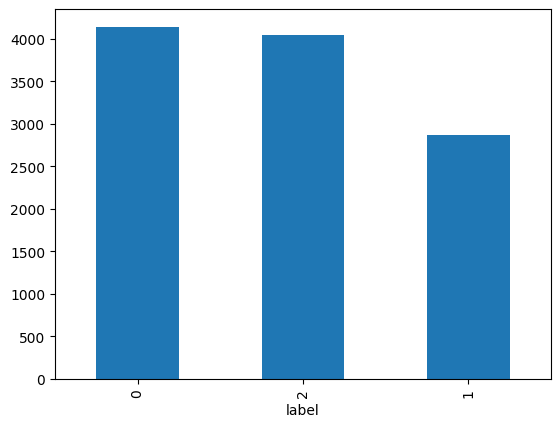

In [3]:
# Plot label distribution
training_data['label'].value_counts().plot(kind='bar')
plt.show()

In [4]:
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer

roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base", truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
from torch.utils.data import Dataset, DataLoader

class BertSentenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        self.X = self.data['premise'] + '[SEP]' + self.data['hypothesis']
        self.y = self.data['label']

        self.encoded = self.tokenizer(self.X.tolist(), padding=True, truncation=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encoded['input_ids'][idx],
            'attention_mask': self.encoded['attention_mask'][idx],
            'label': self.y.iloc[idx]
        }

bert_train_dataset = BertSentenceDataset(training_data, roberta_tokenizer)
bert_test_dataset = BertSentenceDataset(test_data, roberta_tokenizer)

In [6]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "entailment", 1: "neutral", 2: "contradiction"}
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}
num_labels = len(id2label)

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels, id2label=id2label, label2id=label2id)

/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

training_args = TrainingArguments(
    output_dir="roberta-base-sentence-relation",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [8]:
print(f"Running on device: {training_args.device}")

Running on device: cuda:0


In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset,
    tokenizer=roberta_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 26/27650 [00:12<3:31:25,  2.18it/s]

KeyboardInterrupt: 

In [ ]:
# Get the best model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base-sentence-relation/checkpoint-4816', num_labels=num_labels, id2label=id2label, label2id=label2id)

# Evaluate the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset,
    tokenizer=None,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.evaluate()

100%|██████████| 86/86 [00:08<00:00, 10.50it/s]


{'eval_loss': 1.6948167085647583,
 'eval_accuracy': 0.7991266375545851,
 'eval_f1': 0.7975053326129699,
 'eval_precision': 0.7997977316986625,
 'eval_recall': 0.7971155023486721,
 'eval_runtime': 8.2844,
 'eval_samples_per_second': 165.854,
 'eval_steps_per_second': 10.381}